# Elliptical inclusion swelling

- Swelling of of an elliptical inclusion in a matrix
- This is a two-dimensional plane-strain simulation



# Degrees of freedom
- Displacement: u
- pressure: p
- chemical potential: mu
- concentration: c

# Units
- Length: mm
- Mass: kg
- Time: s
- Mass density: kg/mm^3
- Force: milliN
- Stress: kPa 
- Energy: microJ
- Temperature: K
- Amount of substance: mol
- Species concentration: mol/mm^3
- Chemical potential: milliJ/mol
- Molar volume: mm^3/mol
- Species diffusivity: mm^2/s
- Gas constant: microJ/(mol K)

### Software:
- Dolfinx v0.8.0

In the collection "Example Codes for Coupled Theories in Solid Mechanics,"

By Eric M. Stewart, Shawn A. Chester, and Lallit Anand.

https://solidmechanicscoupledtheories.github.io/

# Import modules

In [1]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile

# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, sin, acos, ge, le, outer, tanh,\
                 cosh, atan, atan2)

# basix finite elements (necessary for dolfinx v0.8.0)
import basix
from basix.ufl import element, mixed_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime

# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [2]:
# Matrix edge length
L0  = 50 
# Ellipse major axis
a0 = 2 
# Ellipse minor axis
b0 = 1 

# Read in the 2D mesh and cell tags
with XDMFFile(MPI.COMM_WORLD,"meshes/elliptical_inclusion.xdmf",'r') as infile:
    domain = infile.read_mesh(name="Grid",xpath="/Xdmf/Domain")
    cell_tags = infile.read_meshtags(domain,name="Grid")
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)

# Also read in 1D facets for applying BCs
with XDMFFile(MPI.COMM_WORLD,"meshes/facet_elliptical_inclusion.xdmf",'r') as infile:
    facet_tags = infile.read_meshtags(domain,name="Grid")

# A single point at the center of the inclusion for "grounding" the displacement of the inclusion
def ground(x):
    return np.logical_and(np.isclose(x[0], 0), np.isclose(x[1], 0))

x = ufl.SpatialCoordinate(domain)

**Print out the unique cell number indices**

In [3]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[cell_tags.indices]=cell_tags.values   # populating the array with facet tag index numbers
print(np.unique(cell_tags.values))           # printing the unique indices

# Gmsh numbering
# Physical Surface("inclusion", 18)  
# //+
# Physical Surface("matrix", 19)  

[18 19]


**Print out the unique edge index numbers**

In [4]:
top_imap = domain.topology.index_map(1)      # index map of 1D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

# Gmsh numbering:
# Physical Curve("left", 13) 
# //+
# Physical Curve("right", 14) 
# //+
# Physical Curve("bottom", 15)  
# //+
# Physical Curve("top", 16)  
# //+
# Physical Curve("inclusion_curve", 17)  


[13 14 15 16 17]


**Visualize the reference configuration**

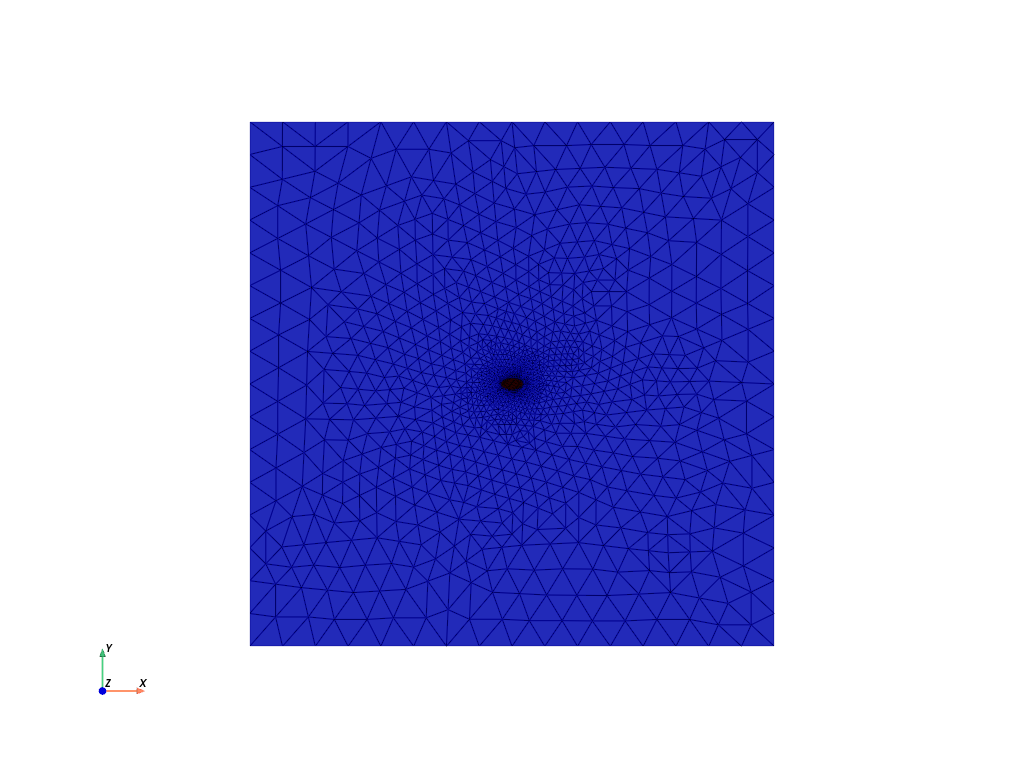

In [5]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True, opacity=0.25) 

# Add colored 2D surfaces for the named surfaces
inclusion = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim,cell_tags.indices[cell_tags.values==18]) )
matrix = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim,cell_tags.indices[cell_tags.values==19]) )
#
actor   = plotter.add_mesh(inclusion,  show_edges=False,color="red") 
actor2  = plotter.add_mesh(matrix,     show_edges=False,color="blue")  

plotter.view_xy()

#labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
labels = dict(xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

plotter.screenshot("results/elliptical_inclusion_mesh.png")

from IPython.display import Image
Image(filename='results/elliptical_inclusion_mesh.png') 

# # Use the following  commands for a  zoom-able  view
# if not pyvista.OFF_SCREEN:
#     plotter.show()
# else:
#     plotter.screenshot("elliptical_inclusion_mesh.png")

## Define boundary and volume integration measure

In [6]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 4})

# Create facet to cell connectivity required to determine boundary facets.
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

# #  Define facet normal
n2D = ufl.FacetNormal(domain)
n = ufl.as_vector([n2D[0], n2D[1], 0.0]) # define n as a 3D vector for later use

# Material parameters

In [7]:
# A function for constructing spatially varying (piecewise-constant) material parameters

# Need some extra infrastructure for the spatially-discontinuous material property fields
Vmat = functionspace(domain, ("DG", 0)) # create a DG0 function space on the domain

# Define function ``mat'' for assigning different values for material properties
# for the inclusion and tthe matrix
#
def mat(prop_val_inclusion, prop_val_matrix):

    # Define an empty "prop" material parameter function,
    # which lives on the DG0 function space.
    prop = Function(Vmat)
    
    # Now, actualy assign the desired values of the material properies to the new field.
    #
    coords = Vmat.tabulate_dof_coordinates()
    #
    # loop over the coordinates and assign the relevant material property, 
    # based on the local cell tag number.
    for i in range(coords.shape[0]):
        if cell_tags.values[i] == 18:
            prop.vector.setValueLocal(i, prop_val_inclusion)
        elif cell_tags.values[i] == 19:
            prop.vector.setValueLocal(i, prop_val_matrix)   
    return prop

In [8]:
Gshear_0= mat(0.5, 0.3)                              # Shear modulii in the two materials, kPa
lambdaL = Constant(domain,PETSc.ScalarType(1000))    # Locking stretch large number for a Neo-Hokkean material
Kbulk   = mat(500,300)                               # Bulk modulii in the two materials, kPa
Omega   = mat(1.E5,0.1)                              # Molar volume of fluid
D       = mat(5.0e-3, 5.0E-3)                        # Diffusivity of fluid
chi     = mat(0.1,0.9)                               # Flory-Huggins chi parameter for the two materials
#
theta0  = Constant(domain,PETSc.ScalarType(298) )           # Reference temperature
R_gas   = Constant(domain,PETSc.ScalarType(8.3145e6))       # Gas constant
RT      = Constant(domain,PETSc.ScalarType(8.3145e6*theta0))
#
phi0    = Constant(domain,PETSc.ScalarType(0.999))                # Initial polymer volume fraction
mu0     = Constant(domain,PETSc.ScalarType(ln(1.0-phi0) + phi0 )) # Initial chemical potential
c0      = Constant(domain,PETSc.ScalarType((1/phi0) - 1))         # initial concentration

**Visualize the spatially varying shear modulus**

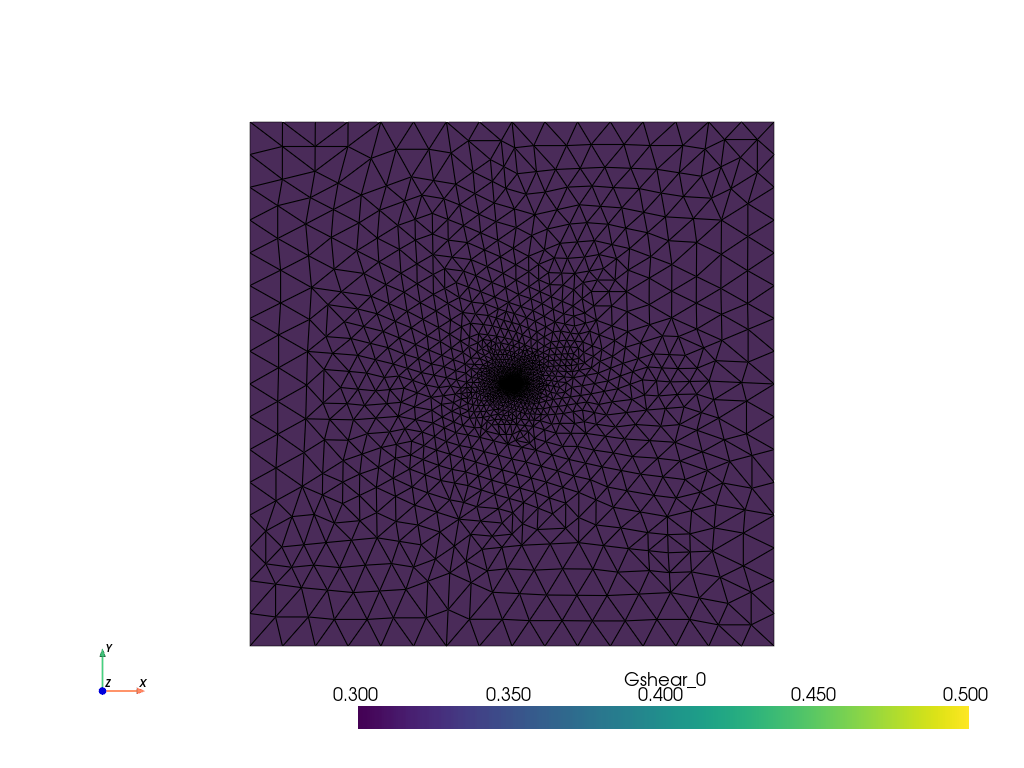

In [9]:
pyvista.set_jupyter_backend('html')
pyvista.start_xvfb()

# Prepare the gshear field for plotting
V = functionspace(domain,("DG",1)) # for some reason, we need a degree 1 DG function space in order to plot in Pyvista.
vtkdata = vtk_mesh(V)  
grid = pyvista.UnstructuredGrid(*vtkdata)
# 
grid["Gshear_0"] = Gshear_0.x.array # interpolate the Gshear_0 data onto the DG1 space.
#
grid.set_active_scalars("Gshear_0")
actor = plotter.add_mesh(grid, show_edges=True) # plot Gshear_0 values.

plotter.view_xy()

#labels = dict(xlabel='X', ylabel='Y', zlabel='Z')
labels = dict(xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

plotter.screenshot("results/plate_mesh_Gshear_0.png")

from IPython.display import Image
Image(filename='results/plate_mesh_Gshear_0.png') 

# if not pyvista.OFF_SCREEN:
#     plotter.show()
# else:
#     plotter.screenshot("results/plate_mesh_Gshear_0.png")

# Simulation time-control related parameters

In [10]:
t    = 0.0        # initialization of time
Ttot = 3600*2     # total simulation time 
ttd  = 300        # Decay time constant
dt   = 10      # Fixed step size

# Expression for increasing  the chemical potential
#
def muRamp(t):
    return mu0*exp(-t/ttd)

# Function spaces

In [11]:
# Define function space, both vectorial and scalar
# 
U2 = element("Lagrange", domain.basix_cell(), 2, shape=(2,)) # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1) # For pressure, chemical potential and  species concentration
#                                      
TH = mixed_element([U2, P1, P1, P1])  # Taylor-Hood style mixed element
ME = functionspace(domain, TH)        # Total space for all DOFs

# Define actual functions with the required DOFs
w = Function(ME)
u, p, mu, c = split(w)  # displacement u, pressure p, chemical potential mu, and concentration c

# A copy of functions to store values in the previous step for time-stepping
w_old = Function(ME)
u_old,  p_old, mu_old, c_old = split(w_old)   

# Define test functions    
u_test, p_test,  mu_test, c_test = TestFunctions(ME)  

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)                  

  

# Initial conditions

- The initial conditions for $\mathbf{u}$ and $p$ are zero everywhere.
- These are imposed automatically, since we have not specified any non-zero initial conditions.
- We do, however, need to impose the uniform initial conditions for $\mu=\mu_0$ and $\hat{c} = \hat{c}_0$ which correspond to $\phi_0 = 0.999$. This is done below.

In [12]:
# Assign initial  normalized chemical potential  mu0 to the domain
w.sub(2).interpolate(lambda x: np.full((x.shape[1],),  mu0))
w_old.sub(2).interpolate(lambda x: np.full((x.shape[1],), mu0))  

# Assign initial  value of normalized concentration  c0 to the domain
w.sub(3).interpolate(lambda x: np.full((x.shape[1],),  c0))
w_old.sub(3).interpolate(lambda x: np.full((x.shape[1],), c0))   

# Subroutines for kinematics and constitutive equations

In [13]:
# Special gradient operators for plane strain 
#
# Gradient of vector field u   
def pe_grad_vector(u):
    
    grad_u = grad(u)
    
    pe_grad_u = ufl.as_tensor([ [grad_u[0,0], grad_u[0,1], 0.0],
                                [grad_u[1,0], grad_u[1,1], 0.0],
                                [        0.0,         0.0, 0.0] ]) 
    return pe_grad_u

# Gradient of scalar field y
# (just need an extra zero for dimensions to work out)
def pe_grad_scalar(y):
    
    grad_y = grad(y)
    
    pe_grad_y = ufl.as_vector([grad_y[0], grad_y[1], 0.0])
    
    return pe_grad_y

# Plane strain deformation gradient 
def F_pe_calc(u):
    
    dim = len(u)                # dimension of problem (2)
    
    Id = Identity(dim)          # 2D Identity tensor
    
    F = Id + grad(u)            # 2D Deformation gradient
      
    F_pe =  ufl.as_tensor([ [F[0,0], F[0,1], 0.0],
                            [F[1,0], F[1,1], 0.0],
                            [   0.0,    0.0, 1.0] ]) # Full plane strain F
    return F_pe

def lambdaBar_calc(u):
    F = F_pe_calc(u)
    C = F.T*F
    Cdis = J**(-2/3)*C
    I1 = tr(Cdis)
    lambdaBar = sqrt(I1/3.0)
    return lambdaBar

#---------------------------------------------------
# Calculate zeta
#---------------------------------------------------
def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u)
    # Use Pade approximation of Langevin inverse
    z    = lambdaBar/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep simulation from blowing up
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta = (lambdaL/(3*lambdaBar))*beta
    return zeta

#---------------------------------------------------
# Calculate zeta0
#---------------------------------------------------
def zeta0_calc():
    # Use Pade approximation of Langevin inverse (A. Cohen, 1991)
    z    = 1/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep from blowing up
    beta0 = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta0 = (lambdaL/3)*beta0
    return zeta0

#---------------------------------------------------
# Subroutine for calculating the elastic jacobian Je
#---------------------------------------------------
def Je_calc(u,c):
    F = F_pe_calc(u)  
    detF = det(F)   
    #
    detFs = 1.0 + c          # = Js
    Je    = (detF/detFs)     # = Je
    return   Je    

#----------------------------------------------
# Subroutine for calculating the Piola  stress
#----------------------------------------------
def Piola_calc(u,p):
    F     = F_pe_calc(u)
    zeta  = zeta_calc(u)
    zeta0 = zeta0_calc()
    Piola = (zeta*F - zeta0*inv(F.T) ) - J*p*inv(F.T)/Gshear_0
    return Piola

#--------------------------------------------------------------
# Subroutine for calculating the normalized species flux
#--------------------------------------------------------------
def Flux_calc(u, mu, c):
    F = F_pe_calc(u) 
    #
    Cinv = inv(F.T*F) 
    #
    Mob = (D*c)/(Omega*RT)*Cinv
    #
    Jmat = - RT* Mob * grad(mu)
    return Jmat

# Evaluate kinematics and constitutive relations

In [14]:
# Kinematics
F = F_pe_calc(u)
J = det(F)  # Total volumetric jacobian
#
lambdaBar = lambdaBar_calc(u)
#
# Elastic volumetric Jacobian
Je     = Je_calc(u,c)                    
Je_old = Je_calc(u_old,c_old)

#  Normalized Piola stress
Piola = Piola_calc(u, p)

#  Normalized species  flux
Jmat = Flux_calc(u, mu, c)


# Weak forms

In [15]:
# Residuals:
# Res_0: Balance of forces (test fxn: u)
# Res_1: Pressure variable (test fxn: p)
# Res_2: Balance of mass   (test fxn: mu)
# Res_3: Auxiliary variable (test fxn: c)

# Time step field, constant within body
dk = Constant(domain, PETSc.ScalarType(dt))

# The weak form for the equilibrium equation
Res_0 = inner(Piola , pe_grad_vector(u_test) )*dx

# The weak form for the auxiliary pressure variable 
Res_1 = dot((p*Je/Kbulk + ln(Je)) , p_test)*dx

# The weak form for the mass balance of solvent      
Res_2 = dot((c - c_old)/dk, mu_test)*dx \
        -  Omega*dot(Jmat , pe_grad_scalar(mu_test) )*dx      

# The weak form for the concentration
fac = 1/(1+c)
fac1 =  mu - ( ln(1.0-fac)+ fac + chi*fac*fac)
fac2 = - (Omega*Je/RT)*p 
fac3 = - (1./2.) * (Omega/(Kbulk*RT)) * ((p*Je)**2.0)
fac4 = fac1 + fac2 + fac3
#
Res_3 = dot(fac4, c_test)*dx
     
# Total weak form
Res = Res_0 + Res_1 + Res_2 + Res_3

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [16]:
# results file name
results_name = "gel_elliptical_inclusion_growth"

# Function space for projection of results
U1 = element("DG", domain.basix_cell(), 1, shape=(2,))  # For displacement
P0 = element("DG", domain.basix_cell(), 1)              # For  pressure, chemical potential, and concentration 
T1 = element("DG", domain.basix_cell(), 1, shape=(3,3)) # For stress tensor

V1 = fem.functionspace(domain, P0) # Scalar function space
V2 = fem.functionspace(domain, U1) # Vector function space
V3 = fem.functionspace(domain, T1) # Tensor function space

# basic fields to write to output file
u_vis = Function(V2)
u_vis.name = "disp"

p_vis = Function(V1)
p_vis.name = "p"

mu_vis = Function(V1)
mu_vis.name = "mu"

c_vis = Function(V1)
c_vis.name = "c"


# calculated fields to write to output file
phi = 1/(1+c)
phi_vis = Function(V1)
phi_vis.name = "phi"
phi_expr = Expression(phi,V1.element.interpolation_points())

J_vis = Function(V1)
J_vis.name = "J"
J_expr = Expression(J,V1.element.interpolation_points())

lambdaBar_vis = Function(V1)
lambdaBar_vis.name = "lambdaBar"
lambdaBar_expr = Expression(lambdaBar,V1.element.interpolation_points())

P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Piola[0,0],V1.element.interpolation_points())
#
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Piola[1,1],V1.element.interpolation_points())
#
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Piola[2,2],V1.element.interpolation_points())

# Mises stress
T   = Piola*F.T/J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_vis= Function(V1,name="Mises")
Mises_expr = Expression(Mises,V1.element.interpolation_points())

# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, mu_vis, c_vis, phi_vis, J_vis, P11, P22, P33, 
        lambdaBar_vis,Mises_vis,
    ],
    engine="BP4",
)

def writeResults(t):
       # Output field interpolation 
       u_vis.interpolate(w.sub(0))
       p_vis.interpolate(w.sub(1))
       mu_vis.interpolate(w.sub(2))
       c_vis.interpolate(w.sub(3))
       phi_vis.interpolate(phi_expr)
       J_vis.interpolate(J_expr)
       P11.interpolate(P11_expr)
       P22.interpolate(P22_expr)
       P33.interpolate(P33_expr)
       lambdaBar_vis.interpolate(lambdaBar_expr)
       Mises_vis.interpolate(Mises_expr)

       # Write output fields
       file_results.write(t) 
        

# Infrastructure for pulling out time history  results data (displacement, force, etc.)

In [17]:
# Identify point for reporting dislacement
pointForDispA = np.array([a0,0.0,0.0])   
pointForDispB = np.array([0.0,b0,0.0])   
pointForDispC = np.array([0.0,0.0,0.0])

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForDispA)
colliding_cells_A = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForDispA).array

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForDispB)
colliding_cells_B = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForDispB).array

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForDispC)
colliding_cells_C = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForDispC).array


# Analysis Step

In [18]:
# Give the step a descriptive name
step = "Swell"

## Boundary conditions

In [19]:
# Gmsh numbering:
# Physical Curve("left", 13) 
# //+
# Physical Curve("right", 14) 
# //+
# Physical Curve("bottom", 15)  
# //+
# Physical Curve("top", 16)  
# //+
# Physical Curve("inclusion_curve", 17)  

# Constant for applied  chemical potential
mu_cons = Constant(domain,PETSc.ScalarType(muRamp(0)))

# Identify the specific DOFs which will be constrained
left_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(13))
left_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(13))
#
right_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(14))
right_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(14))
#
bottom_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(15))
bottom_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(15))
#
top_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(16))
top_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(16))
#
inclusion_mu_dofs  = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(17))

# building Dirichlet BCs
bcs_1 = dirichletbc(0.0, left_u1_dofs, ME.sub(0).sub(0))   # u1 fix left
bcs_2 = dirichletbc(0.0, left_u2_dofs, ME.sub(0).sub(1))   # u2 fix left
#
bcs_3 = dirichletbc(0.0, right_u1_dofs, ME.sub(0).sub(0))   # u1 fix right
bcs_4 = dirichletbc(0.0, right_u2_dofs, ME.sub(0).sub(1))   # u2 fix right
#
bcs_5 = dirichletbc(0.0, bottom_u1_dofs, ME.sub(0).sub(0))  # u1 fix bottom
bcs_6 = dirichletbc(0.0, bottom_u2_dofs, ME.sub(0).sub(1))  # u2 fix bottom
#
bcs_7 = dirichletbc(mu_cons, inclusion_mu_dofs, ME.sub(2))  # mu_cons- inclusion boundary

# Zero displacement bc for  center of node of inclusion
V0, submap = ME.sub(0).collapse()
fixed_u_dofs = fem.locate_dofs_geometrical((ME.sub(0), V0), ground)
fixed_disp = Function(V0)
fixed_disp.interpolate(lambda x: np.stack(( np.zeros(x.shape[1]), np.zeros(x.shape[1]) ) ) )
#
bcs_8 = dirichletbc(fixed_disp, fixed_u_dofs, ME.sub(0))     # u fix -  center node of inclusion

# Complete set of bcs
bcs = [bcs_1, bcs_2, bcs_3, bcs_4, bcs_5, bcs_6, bcs_7, bcs_8]

## Define the nonlinear variational problem

In [20]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# The global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly" 
opts[f"{option_prefix}pc_type"] = "lu"       # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

# Initialize arrays for storing output history

In [21]:
# Arrays for storing output history
totSteps = 100000
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 
timeHist2 = np.zeros(shape=[totSteps]) 
#
timeHist1[0]  = a0    # initial  value of major axis  of ellipse
timeHist2[0]  = b0    # initial  value of minor axis  of ellipse

# Initialize a counter for reporting data
ii = 0

# Write initial state to file
writeResults(t=0.0) 

##  Start calculation loop

In [22]:
# Print  message for simulation start
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
    
    # # smaller time-step needed for initiation of buckling
    # if (t>=2000 and t<=3600): 
    #     dt = 10
    #     dk = Constant(domain, PETSc.ScalarType(dt))
    # else:
    #     dt = 50
    #     dk = Constant(domain, PETSc.ScalarType(dt))
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    mu_cons.value = float(muRamp(t))
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        print("Ended Early")
        break
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()
    
    # Write output to file
    writeResults(t)
    
    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
    
    
    # Store  output history at a particular point  at current time
    #
    timeHist0[ii] = t                                                            # time
    #
    timeHist1[ii] = a0 +  \
         (w.sub(0).sub(0).eval([a0,0.0,0.0],colliding_cells_A[0])[0]  \
         - w.sub(0).sub(0).eval([0.0,0.0,0.0],colliding_cells_C[0])[0])   #  major axis of ellipse
    #
    timeHist2[ii] =b0 +  \
        (w.sub(0).sub(1).eval([0.0,b0,0.0],colliding_cells_B[0])[0]  \
         - w.sub(0).sub(1).eval([0.0,0.0,0.0],colliding_cells_C[0])[0])   #  minor axis of ellipse

    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Increment: {}, Iterations: {}".\
              format(step, ii, iter))
        print("      Simulation Time: {} s  of  {} s".\
              format(round(t,4), Ttot))
        print()  
    
# close the output file.
file_results.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Swell | Increment: 1, Iterations: 6
      Simulation Time: 10.0 s  of  7200 s

Step: Swell | Increment: 2, Iterations: 5
      Simulation Time: 20.0 s  of  7200 s

Step: Swell | Increment: 3, Iterations: 4
      Simulation Time: 30.0 s  of  7200 s

Step: Swell | Increment: 4, Iterations: 4
      Simulation Time: 40.0 s  of  7200 s

Step: Swell | Increment: 5, Iterations: 4
      Simulation Time: 50.0 s  of  7200 s

Step: Swell | Increment: 6, Iterations: 4
      Simulation Time: 60.0 s  of  7200 s

Step: Swell | Increment: 7, Iterations: 4
      Simulation Time: 70.0 s  of  7200 s

Step: Swell | Increment: 8, Iterations: 4
      Simulation Time: 80.0 s  of  7200 s

Step: Swell | Increment: 9, Iterations: 4
      Simulation Time: 90.0 s  of  7200 s

Step: Swell | Increment: 10, Iterations: 4
      Simulation Time: 100.0 s  of  7200 s

Step: Swell | Increment: 11, Iterations: 4
      Simulati

# Plot results

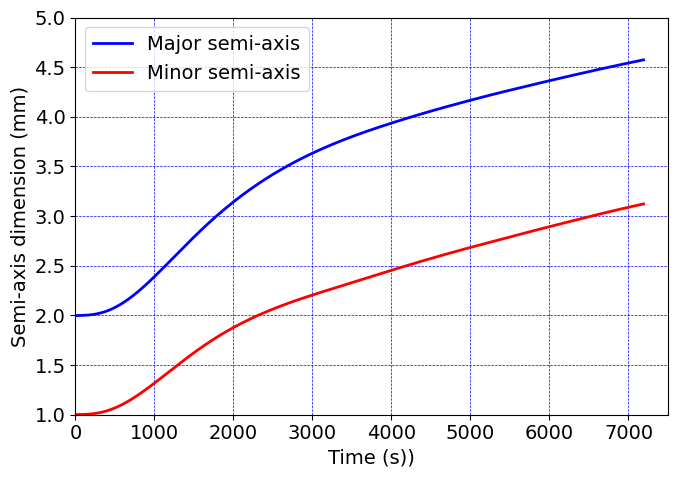

In [23]:
# Set up font size, initialize colors array
font = {'size'   : 14}
plt.rc('font', **font)
#
prop_cycle = plt.rcParams['axes.prop_cycle']
colors     = prop_cycle.by_key()['color']

# Only plot as far as we have time history data
ind = np.argmax(timeHist0[:])

# Create figure for temperature versus  tip-displacement curve.
#
fig = plt.figure() 
ax=fig.gca()  
#---------------------------------------------------------------------------------------------
plt.plot(timeHist0[0:ind], timeHist1[0:ind], c='b', linewidth=2.0, label= "Major semi-axis")
plt.plot(timeHist0[0:ind], timeHist2[0:ind], c='r', linewidth=2.0, label= "Minor semi-axis")
#---------------------------------------------------------------------------------------------
plt.xlim(0,7500)
plt.ylim(1,5)
#
plt.grid(linestyle="--", linewidth=0.5, color='b')
#  
ax.set_xlabel("Time (s))",size=14)
ax.set_ylabel(r'Semi-axis dimension (mm)',size=14)
#ax.set_title(r'Time versus semi-axes dimensions', size=14, weight='normal')
#
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
#ax.xaxis.set_minor_locator(AutoMinorLocator())
#ax.yaxis.set_minor_locator(AutoMinorLocator())
#plt.legend()
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

plt.legend()
# Save figure
fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/gel_elliptical_inclusion_growth.png", dpi=600) 